In [1]:
import os
# Set working directory
os.chdir("D:/ACP")  # Windows path fix: use forward slash or raw string

print("Current Working Directory:", os.getcwd())

Current Working Directory: D:\ACP


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import joblib

In [3]:
# Step 1: Load the datasets (datasets were already splited and saved as csv files, 80,20 split)
train_data = pd.read_csv("acp_train_bert_features.csv") #train data
test_data = pd.read_csv("acp_test_bert_features.csv") #test data
# Step 2: Separate labels and features
y_train, X_train = train_data.iloc[:, 2], train_data.iloc[:, 3:] # third column: Label, # from fourth column onward: features
y_test, X_test = test_data.iloc[:, 2], test_data.iloc[:, 3:]

In [4]:
# Define GaussianNB model and parameter grid
gnb_model = GaussianNB() #it doesnnot need Random state for reproducibility
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5] #var_smoothing means the variance of the data. The smaller the value, the more the variance
}

# Apply GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=gnb_model,
    param_grid=param_grid,
    scoring='accuracy', # use accuracy as the scoring metric
    cv=5,
    n_jobs= 1, #use all available cores, -1 value means using all cores, 0 means using 1 core, 1 means using 2 cores and so on
    verbose=2 # print grid search results, verbose=0 means silent, 1 means print progress, 2 means print progress and results
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-07; total time=   0.0s
[CV] END ................................var_smoo

GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]},
             scoring='accuracy', verbose=2)

In [5]:
#Print best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best model from GridSearchCV
best_gnb_model = grid_search.best_estimator_

# Save best hyperparameters to a file
with open('best_model_info_gnb_protbert.txt', 'w') as f:
    f.write("Best Hyperparameters:\n")
    for param, value in grid_search.best_params_.items():
        f.write(f"{param}: {value}\n")

print("Best model information has been saved to 'best_model_info_gnb_protbert.txt'")

Best Hyperparameters: {'var_smoothing': 1e-09}
Best model information has been saved to 'best_model_info_gnb_protbert.txt'


In [6]:
#save best model to a file
joblib.dump(best_gnb_model, "best_gnb_protbert_model.pkl")

['best_gnb_protbert_model.pkl']

In [7]:
# Fit the model on the training data
best_gnb_model.fit(X_train, y_train)

# Evaluate on the test dataset
y_test_pred = best_gnb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Confusion Matrices
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Data):\n", confusion_matrix_test)

# Sensitivity and Specificity calculation
def calculate_sensitivity_specificity(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sensitivity_test, specificity_test = calculate_sensitivity_specificity(confusion_matrix_test)
print("Test Data - Sensitivity:", sensitivity_test, "Specificity:", specificity_test)

Test Accuracy: 0.7351351351351352
Confusion Matrix (Test Data):
 [[70 21]
 [28 66]]
Test Data - Sensitivity: 0.7021276595744681 Specificity: 0.7692307692307693


In [8]:
from sklearn.metrics import f1_score
# calculation of F1 score
f1_test = f1_score(y_test, y_test_pred)
print("F1 Score (Test Data):", f1_test)

F1 Score (Test Data): 0.7292817679558011


In [9]:
#calculation of classification report for test and evaluation data
print("Classification Report (Test Data):\n", classification_report(y_test, y_test_pred))

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.71      0.77      0.74        91
           1       0.76      0.70      0.73        94

    accuracy                           0.74       185
   macro avg       0.74      0.74      0.74       185
weighted avg       0.74      0.74      0.73       185



In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
# Compute metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Matthews Correlation Coefficient (MCC):", mcc)

Precision: 0.7586206896551724
Recall: 0.7021276595744681
Matthews Correlation Coefficient (MCC): 0.4721317819565966


Test Data ROC AUC: 0.7974047229366379
Test Data FPR: [0.         0.17582418 0.18681319 0.18681319 0.1978022  0.1978022
 0.20879121 0.20879121 0.23076923 0.23076923 0.25274725 0.25274725
 0.27472527 0.27472527 0.28571429 0.28571429 0.30769231 0.30769231
 0.34065934 0.34065934 0.37362637 0.37362637 0.43956044 0.43956044
 0.45054945 0.45054945 0.47252747 0.47252747 0.50549451 0.50549451
 0.7032967  0.7032967  0.79120879 0.79120879 0.96703297 0.96703297
 0.98901099 0.98901099 1.        ]
Test Data TPR: [0.         0.56382979 0.56382979 0.58510638 0.58510638 0.64893617
 0.64893617 0.69148936 0.69148936 0.71276596 0.71276596 0.77659574
 0.77659574 0.78723404 0.78723404 0.80851064 0.80851064 0.81914894
 0.81914894 0.86170213 0.86170213 0.87234043 0.87234043 0.90425532
 0.90425532 0.92553191 0.92553191 0.94680851 0.94680851 0.95744681
 0.95744681 0.96808511 0.96808511 0.9787234  0.9787234  0.9893617
 0.9893617  1.         1.        ]
Test Data Thresholds: [            inf 1.00000000e+000 1.000

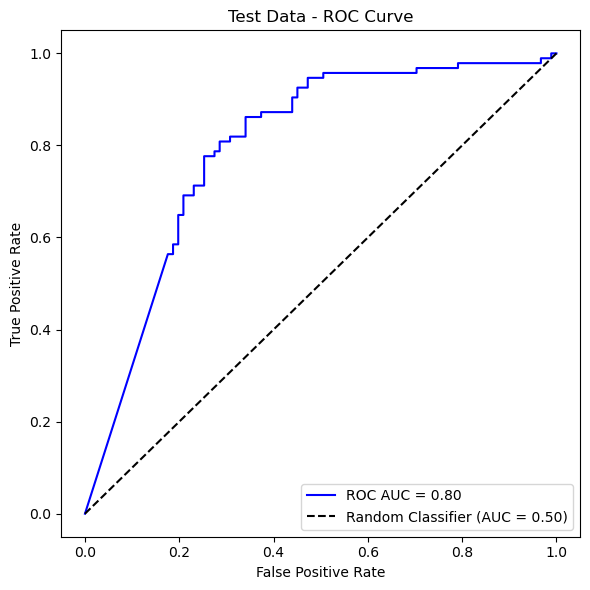

In [11]:
# Evaluate on the test dataset
y_test_pred = best_gnb_model.predict(X_test)
y_test_prob = best_gnb_model.predict_proba(X_test)[:, 1]

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate ROC for test dataset
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Print the values
print("Test Data ROC AUC:", roc_auc_test)
print("Test Data FPR:", fpr_test)
print("Test Data TPR:", tpr_test)
print("Test Data Thresholds:", thresholds_test)

# Create a plot
fig, ax = plt.subplots(figsize=(6, 6))  # This defines 'ax' properly

# Plot ROC curve
ax.plot(fpr_test, tpr_test, label=f"ROC AUC = {roc_auc_test:.2f}", color="blue")
ax.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
ax.set_title("Test Data - ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("gnb_protbert_roc_auc_curve.png", dpi=500)
print("ROC curve saved as 'gnb_protbert_roc_auc_curve.png'.")

# Show the plot
plt.show()

In [12]:
# Perform 10-fold cross-validation on the best model
cross_val_scores = cross_val_score(best_gnb_model, X_train, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cross_val_scores)
print("Mean 10-Fold CV Accuracy:", cross_val_scores.mean())

# save accuracy of each fold to a text file
with open('cv_accuracies_gnb_protbert.txt', 'w') as f:
    f.write("Cross-Validation Accuracies for each fold:\n")
    for i, score in enumerate(cross_val_scores):
        f.write(f"Fold {i+1} Accuracy: {score:.4f}\n")

print("Accuracy of each fold has been saved to 'cv_accuracies_gnb_protbert.txt'")

10-Fold Cross-Validation Accuracy Scores: [0.71621622 0.72972973 0.74324324 0.75675676 0.72972973 0.77027027
 0.77027027 0.67567568 0.69863014 0.73972603]
Mean 10-Fold CV Accuracy: 0.7330248056275454
Accuracy of each fold has been saved to 'cv_accuracies_gnb_protbert.txt'


Mean Accuracy: 73.30
Mean AUC: 0.7959


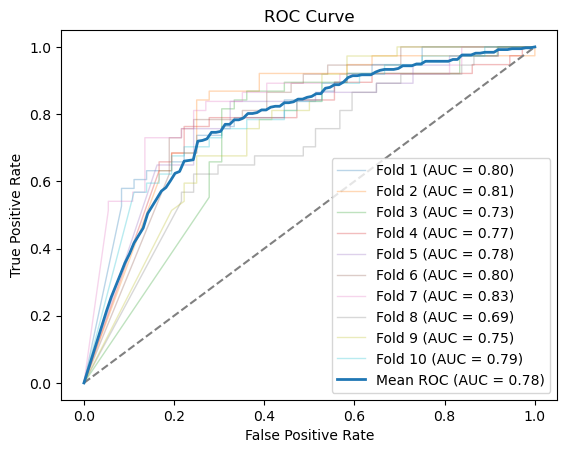

In [13]:
# make roc curve of all folds with mean auc and mean accuracy printed on the plot
mean_accuracy = cross_val_scores.mean() * 100
print(f"Mean Accuracy: {mean_accuracy:.2f}")
# Step 6: Generate ROC Curve
mean_auc = roc_auc_score(y_train, best_gnb_model.predict_proba(X_train)[:, 1])
print(f"Mean AUC: {mean_auc:.4f}")

cv = StratifiedKFold(n_splits=10)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    best_gnb_model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    y_prob = best_gnb_model.predict_proba(X_train.iloc[test_idx])[:, 1]
    fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("cv_roc_curve_gnb_protbert.png", dpi=500)
plt.show()